In [1]:
import pandas as pd 
import numpy as np
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tqdm.pandas()
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 14

In [3]:
data = pd.read_csv("shopee_reviews.csv")
data = data.sample(100000).reset_index(drop=True)
data.head()

C:\Users\Prayag Chawla\AppData\Local\Temp\ipykernel_18868\1320068829.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("shopee_reviews.csv")


,label,text
0,5,Just the right size for miniture cactus. Cute ...
1,5,Box abit smoushed but item received in good co...
2,1,Item posted and receive are totally different....
3,5,"Ordered #1 and #13, but both come in the same ..."
4,5,Have tried trice and the feeling was great. No...


In [4]:
def text_cleaning(x):
    
    text = re.sub('\s+\n+', ' ', x)
    text = re.sub('[^a-zA-Z0-9\.]', ' ', text)
    text = text.split()
    
    text = [word for word in text]
    text = ' '.join(text)
    text = 'startseq '+text+' endseq'
    
    return text

In [5]:
data['text'] = data['text'].progress_apply(text_cleaning)

100%|██████████| 100000/100000 [00:01<00:00, 98146.17it/s]


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [7]:
train = data.iloc[:85000, :]
val = data.iloc[85000:95000, :].reset_index(drop=True)
test = data.iloc[95000:, :].reset_index(drop=True)

In [8]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())
max_length = max(len(caption.split()) for caption in train['text'].tolist())

In [9]:
df_vocab = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word','count'])
df_vocab.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
df_vocab.head()

,word,count
0,startseq,85000
1,endseq,85000
2,the,46461
3,and,37270
4,good,35761


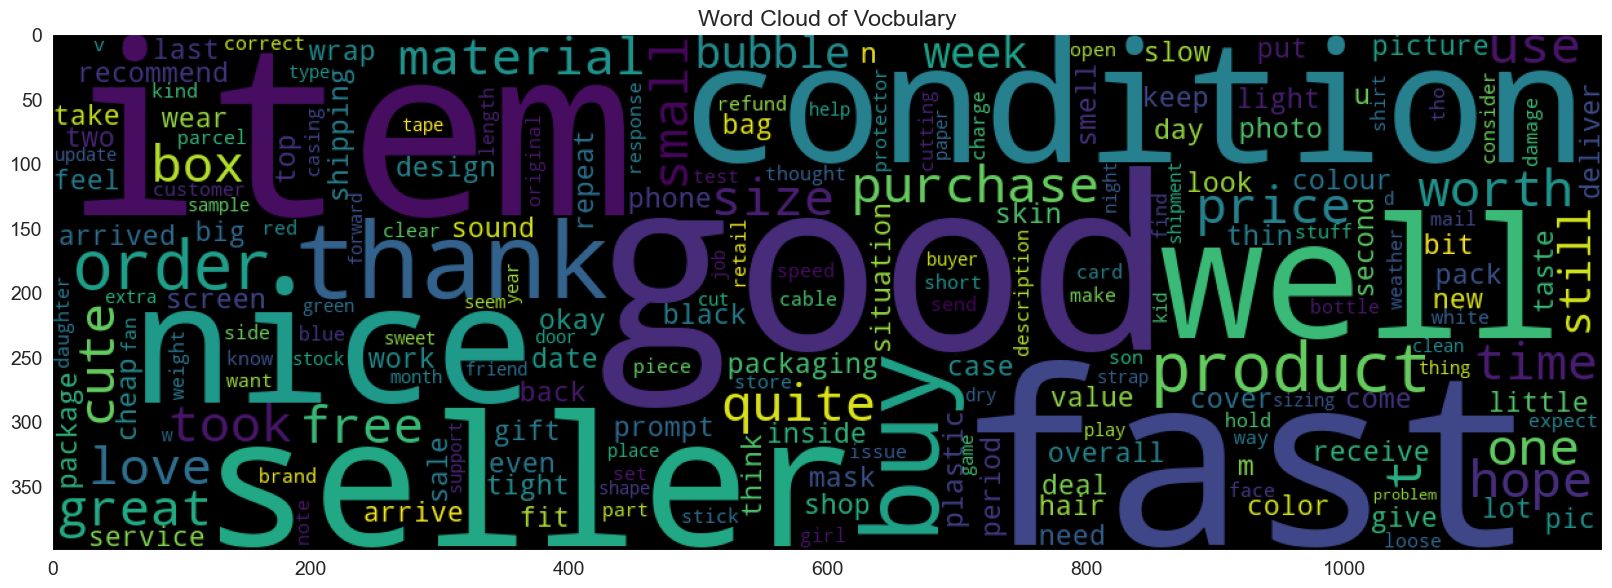

In [10]:
words = ""
words += " ".join(df_vocab['word'].tolist())+" "
wordcloud = WordCloud(width = 1200, height = 400,
                background_color ='black',
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.title('Word Cloud of Vocbulary')
plt.show()

In [11]:
df_vocab.describe()

,count
count,19413.000000
mean,76.158914
std,1199.585317
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,85000.000000


In [12]:
df_vocab[df_vocab['count']>=50]

,word,count
0,startseq,85000
1,endseq,85000
2,the,46461
3,and,37270
4,good,35761
...,...,...
1612,cracks,50
1613,comments,50
1614,tasted,50
1615,egg,50


In [13]:
vocab_size = len(df_vocab[df_vocab['count']>=50])
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['text'].tolist())

In [14]:
data['length'] = data['text'].progress_apply(lambda x: len(x.split(' ')))

100%|██████████| 100000/100000 [00:00<00:00, 286717.68it/s]


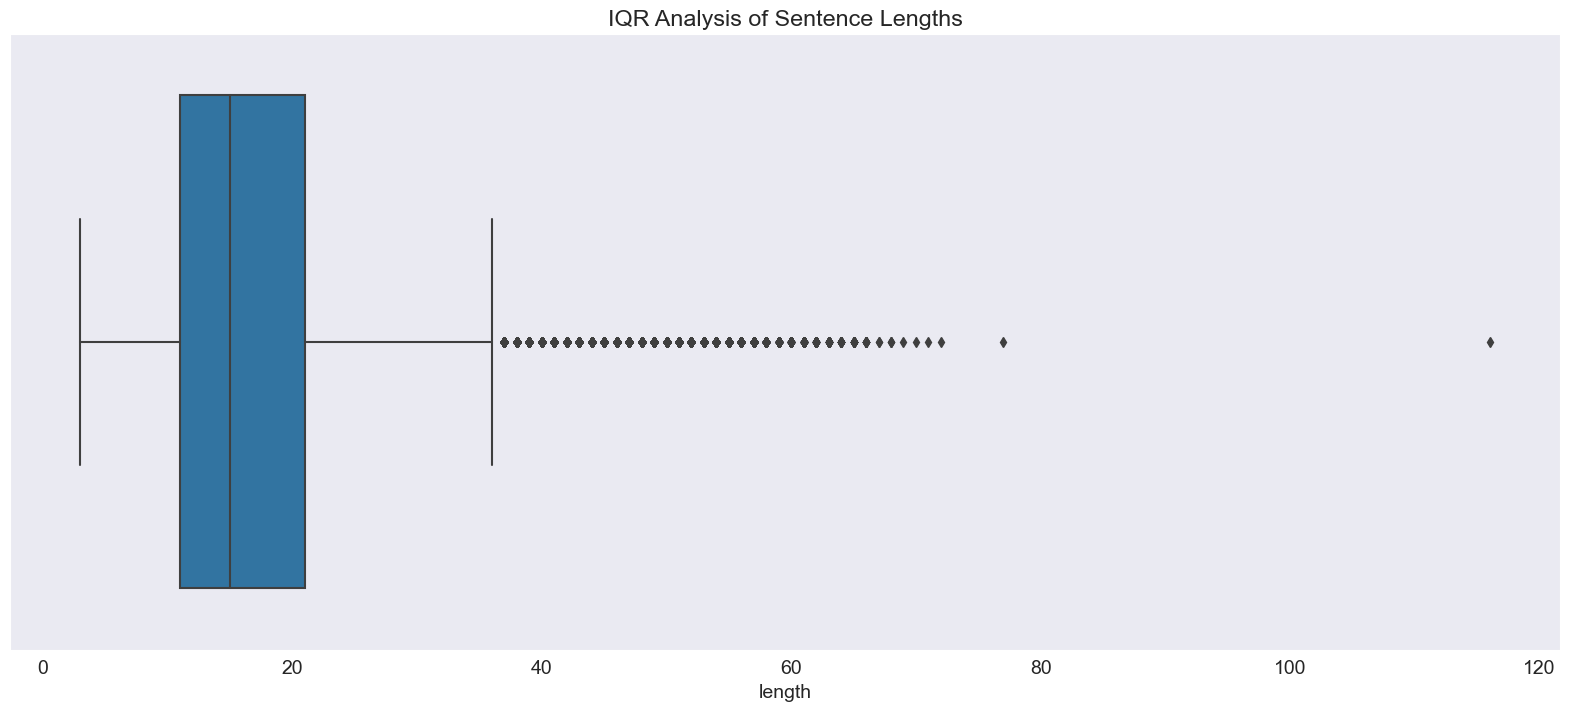

In [15]:
sns.boxplot(x='length', data=data)
plt.title('IQR Analysis of Sentence Lengths')
plt.show()

In [16]:
data.describe()

,length
count,100000.00000
mean,17.40390
std,10.56573
min,3.00000
25%,11.00000
50%,15.00000
75%,21.00000
max,116.00000


In [17]:
max_length = 50
print(train.loc[0, 'text'])
print(tokenizer.texts_to_sequences([train.loc[0, 'text']])[0])

startseq Just the right size for miniture cactus. Cute . Well packed. endseq
[2, 74, 4, 313, 58, 14, 1, 1, 86, 22, 62, 3]


In [18]:
seq = train.loc[0, 'text'].split()
X, y = [], []
for i in range(1,len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    X.append(' '.join(in_seq))
    y.append(out_seq)
    
example = pd.DataFrame(columns=['input','output'])
example['input'] = X
example['output'] = y
example

,input,output
0,startseq,Just
1,startseq Just,the
2,startseq Just the,right
3,startseq Just the right,size
4,startseq Just the right size,for
5,startseq Just the right size for,miniture
6,startseq Just the right size for miniture,cactus.
7,startseq Just the right size for miniture cactus.,Cute
8,startseq Just the right size for miniture cact...,.
9,startseq Just the right size for miniture cact...,Well


In [19]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, batch_size, tokenizer, vocab_size, max_length, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)        
        return X, y
    
    def __get_data(self,batch):
        
        X, y = list(), list()            
        captions = batch.loc[:, self.X_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            max_len = self.max_length if len(seq) > self.max_length else len(seq)
            for i in range(1,max_len):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X.append(in_seq)
                y.append(out_seq)
            
        X, y = np.array(X), np.array(y)
                
        return X, y

In [20]:

train_gen = CustomDataGenerator(train, 'text', 16, tokenizer, vocab_size, max_length)
val_gen = CustomDataGenerator(val, 'text', 16, tokenizer, vocab_size, max_length)
test_gen = CustomDataGenerator(test, 'text', 16, tokenizer, vocab_size, max_length)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, Reshape, 
                                     concatenate, Bidirectional, Dense, Input)

In [22]:
input_layer = Input(shape=(50,))
x = Embedding(vocab_size, 64)(input_layer)
x = Bidirectional(LSTM(100))(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 64)            103488    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              132000    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1617)              325017    
                                                                 
Total params: 560,505
Trainable params: 560,505
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [25]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-0.1*epoch)
    
    
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [27]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[checkpoint, es, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
5312/5312 [==============================] - ETA: 0s - loss: 3.8632
Epoch 1: val_loss improved from 3.97048 to 3.80490, saving model to model.h5
5312/5312 [==============================] - 1529s 288ms/step - loss: 3.8632 - val_loss: 3.8049 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
5312/5312 [==============================] - ETA: 0s - loss: 3.7428
Epoch 2: val_loss improved from 3.80490 to 3.73419, saving model to model.h5
5312/5312 [==============================] - 1366s 257ms/step - loss: 3.7428 - val_loss: 3.7342 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/5
5312/5312 [==============================] - ETA: 0s - loss: 3.6751
Epoch 3: val_loss improved from 3.73419 to 3.69000, saving model to model.h5
5312/5312 [==============================] - 1374s 259ms/step - loss: 3.6751 

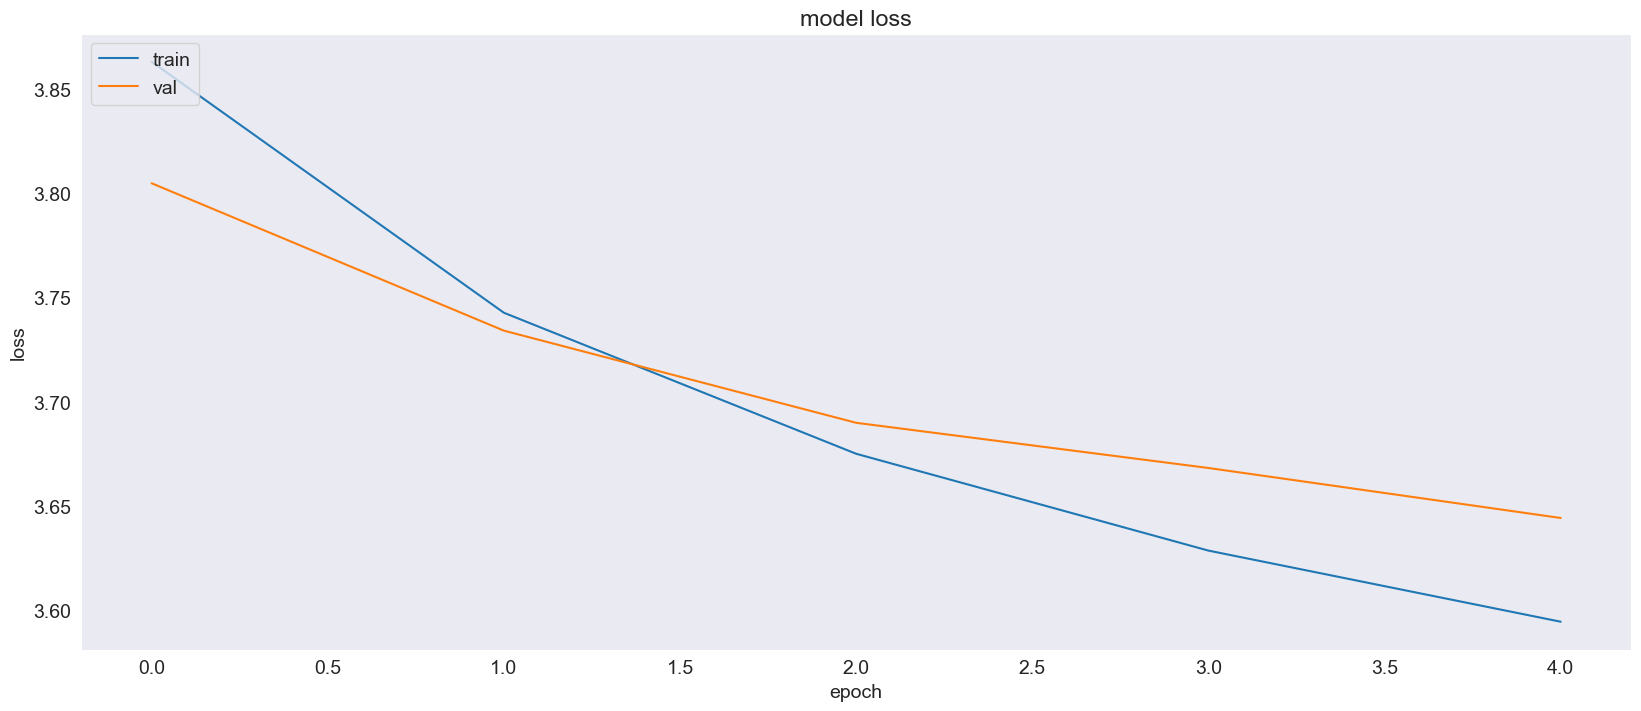

In [28]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [30]:
def predict_sentence(text, model, tokenizer, max_length):
    
    in_text = "startseq " + text
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict(sequence, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text

In [31]:
def beam_search_predictions(text, beam_index = 3):
    in_text = "startseq " + text
    start = tokenizer.texts_to_sequences([in_text])[0]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length)
            preds = model.predict(par_caps, verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx_to_word(i, tokenizer) for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [32]:
sentences = ["overall the product is okay", 
             "exactly like picture", 
             "price could have been cheaper",
             "will recommend this item",
             "useful packaging"]

for sentence in sentences:
    print("Greedy Search: ", predict_sentence(sentence, model, tokenizer, 50))
    print("Beam Search: ", beam_search_predictions(sentence))
    print("\n")

Greedy Search:  startseq overall the product is okay and the <OOV> is very good endseq
Beam Search:  overall the product is okay but the material is soft and comfy


Greedy Search:  startseq exactly like picture endseq
Beam Search:  exactly like picture


Greedy Search:  startseq price could have been cheaper <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> van breaker
Beam Search:  price could have been cheaper than retail store


Greedy Search:  startseq will recommend this item endseq
Beam Search:  will recommend this item to <OOV> my <OOV> <OOV>


Greedy Search:  startseq useful packaging and <OOV> endseq
Beam Search:  useful packaging and delivery was fast too thank you


